In [67]:
import os
import os.path as pt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import scipy

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
ROOT_DIR = '../'
EXP_FORMAT = '\d+g_*' # matches [number]g_[exp]

fs = 100 # sampling freq

In [3]:
# Load data

experiment_list = [x for x in os.listdir(ROOT_DIR) if re.match(EXP_FORMAT, x)]
experiment_meta = {}

for exp_dir in experiment_list:  
    weight, name = exp_dir.split('g_')
    weight = float(weight)
    
    exp_path = pt.join(ROOT_DIR, exp_dir)
    
    csv_paths = [os.path.join(exp_path, x) for x in os.listdir(exp_path) if x.endswith('csv')]
    csv_paths.sort()
    
    experiment_meta[name] = {
        'weight': weight,
        'csv_paths': csv_paths
    }

In [4]:
experiment_meta

{'baseline': {'weight': 0.0,
  'csv_paths': ['../0g_baseline/014B4DCF-BC60-442E-9AF0-B828D9E0871D.csv',
   '../0g_baseline/7AA27344-6799-47D3-A092-CAE987B3AFF8.csv',
   '../0g_baseline/A1258CD0-87EC-4DFF-B3CC-4CE4AEAADD4E.csv']},
 'calculator': {'weight': 132.0,
  'csv_paths': ['../132g_calculator/06F4D8D0-4FD3-42A7-A358-DBE2220620B6.csv',
   '../132g_calculator/0811BB2F-A250-465F-9B4D-D1F49333EEC5.csv',
   '../132g_calculator/CF5B4133-28E8-41A6-BDC0-BECCE5070650.csv']},
 'grape': {'weight': 14.0,
  'csv_paths': ['../14g_grape/4A213547-AB5F-4923-8376-227457A2E638.csv',
   '../14g_grape/95817903-264C-4EA8-8BA4-3D43C9397FC8.csv',
   '../14g_grape/A747A2CA-FE12-4B18-970E-3A379A041D6A.csv']},
 'hole_puncher': {'weight': 155.0,
  'csv_paths': ['../155g_hole_puncher/5814F503-489F-47BD-A3A6-341B80710BB0.csv',
   '../155g_hole_puncher/BCF26EAA-6530-41DF-9733-51D012896D01.csv',
   '../155g_hole_puncher/C38DAC07-4930-4959-B340-B9B6595E0542.csv']},
 'plant': {'weight': 170.0,
  'csv_paths': ['../

In [5]:
# From Lab 3

from scipy.signal import butter,filtfilt

# Define low-pass filter
def butter_lowpass_filter(data, cutoff, fs, order):
	"""
	data: input signal
	cutoff: cut-off frequency, the maximum frequency
			that can pass through the filter
	fs: sampling rate
	order: order of the filter
	"""
	nyq = 0.5 * fs
	normal_cutoff = cutoff / nyq
	# Get the filter coefficients
	b, a = butter(order, normal_cutoff, btype='low', analog=False)
	y = filtfilt(b, a, data)
	return y

# Define high-pass filter
def butter_highpass_filter(data, cutoff, fs, order):
	"""
	data: input signal
	cutoff: cut-off frequency, the minimum frequency
			that can pass through the filter
	fs: sampling rate
	order: order of the filter
	"""
	nyq = 0.5 * fs
	normal_cutoff = cutoff / nyq
	# Get the filter coefficients
	b, a = butter(order, normal_cutoff, btype='high', analog=False)
	y = filtfilt(b, a, data)
	return y

# Define band-pass filter
def butter_bandpass_filter(data, cutoff, fs, order):
	"""
	data: input signal
	cutoff: [low-cut-off frequency, high-cut-off frequency]
	fs: sampling rate
	order: order of the filter
	"""
	nyq = 0.5 * fs
	normal_cutoff = np.asarray(cutoff) / nyq
	# Get the filter coefficients
	b, a = butter(order, normal_cutoff, btype='bandpass', analog=False)
	y = filtfilt(b, a, data)
	return y

In [6]:
def load_obj(obj, ind, subtract_mean=True, filter_freq=False):
    data = pd.read_csv(experiment_meta[obj]['csv_paths'][ind], header=None)
    
    # Translate the signal such that it has zero mean
    if subtract_mean:
        data = data - np.asarray(data.mean(axis=1)).reshape(-1, 1)
    
    # Remove all frequencies that are not 10Hz
    if filter_freq:
        #data = pd.DataFrame(butter_highpass_filter(butter_lowpass_filter(np.asarray(data), 10, fs, 10), 10, fs, 10))
        #data = pd.DataFrame(butter_bandpass_filter(np.asarray(data), (10, 20), fs, 10))
        #data = pd.DataFrame(scipy.ndimage.gaussian_filter1d(np.asarray(data), 3))
        pass
    
    return data

The general hypothesis is that heavier objects should reduce the phone's vibrations; thus, we plot the absolute amplitudes for the vibrations of a few objects.

The absolute amplitude is $|x_i - \bar{x}|$, where $x_i$ are the signal measurements. This measures the displacement from the mean value of the signal.

The mean absolute amplitude is $\frac{\sum_{i=1}^{n}|x_i - \bar{x}|}{n}$, where $n$ is the number of measurements i.e. 1000.

In [7]:
def plot_abs_wave(obj2, window=None, obj1='baseline', i1=0, i2=0, filter_freq=False):
    obj1_data = load_obj(obj1, i1, filter_freq=filter_freq)
    obj2_data = load_obj(obj2, i2, filter_freq=filter_freq)    
    
    if window is None:
        le, re = 0, obj1_data.shape[1]
    else:
        le, re = window
    
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(15, 8))
    fig.suptitle(f'{obj1} vs {obj2} (weight {experiment_meta[obj2]["weight"]}g)')
    
    for i, v in enumerate(['x', 'y', 'z']):
        axes[i].plot(np.abs(obj1_data.loc[i, le:re]), color='blue', linestyle='dotted', alpha=0.5, label=obj1)
        axes[i].plot(np.abs(obj2_data.loc[i, le:re]), color='orange', linestyle='dotted', alpha=0.5, label=obj2)     
        
        axes[i].plot(list(range(le, re)), np.repeat(np.abs(obj1_data.loc[i]).mean(), re-le), color='blue')
        axes[i].plot(list(range(le, re)), np.repeat(np.abs(obj2_data.loc[i]).mean(), re-le), color='orange')
        
        axes[i].set_xlabel(v)
        
    fig.tight_layout()
    plt.legend()

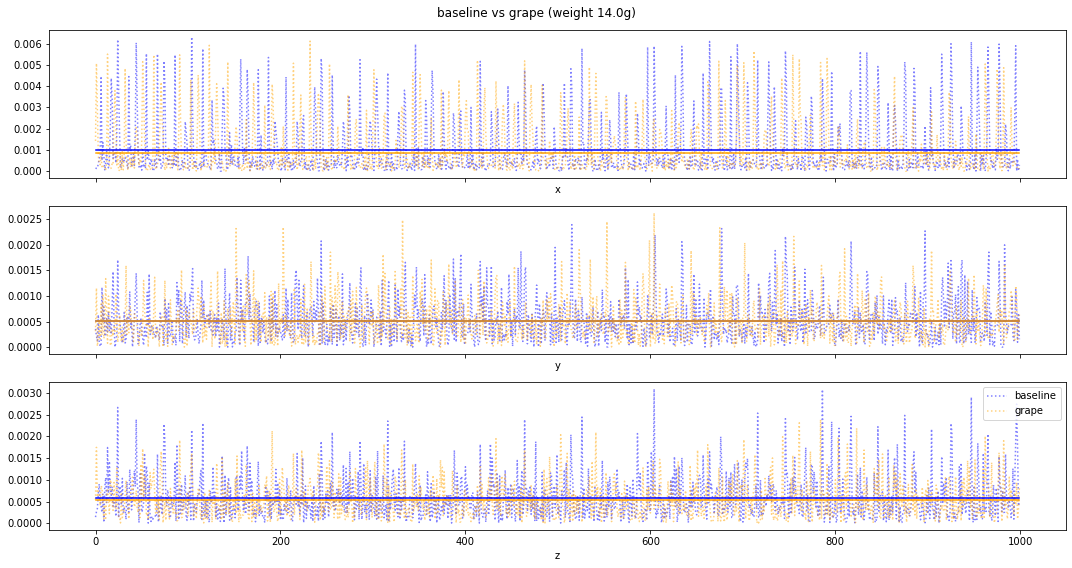

In [8]:
plot_abs_wave('grape')

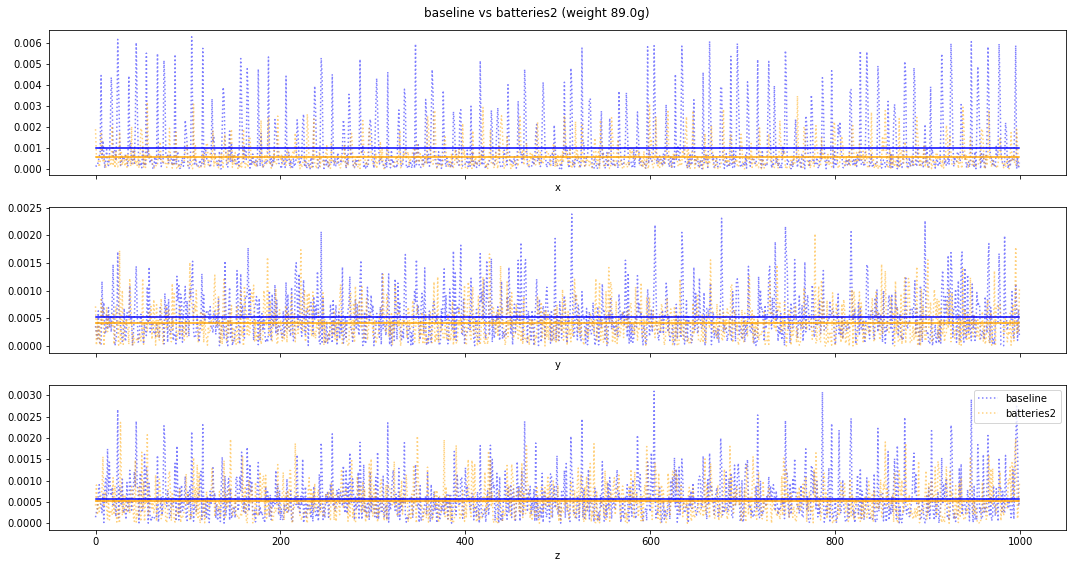

In [9]:
plot_abs_wave('batteries2')

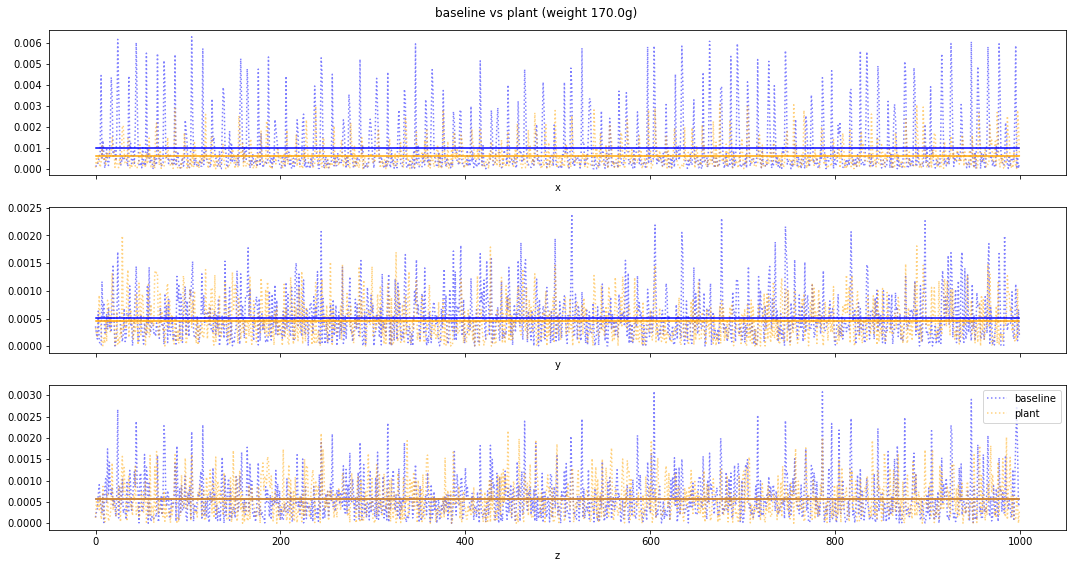

In [10]:
plot_abs_wave('plant')

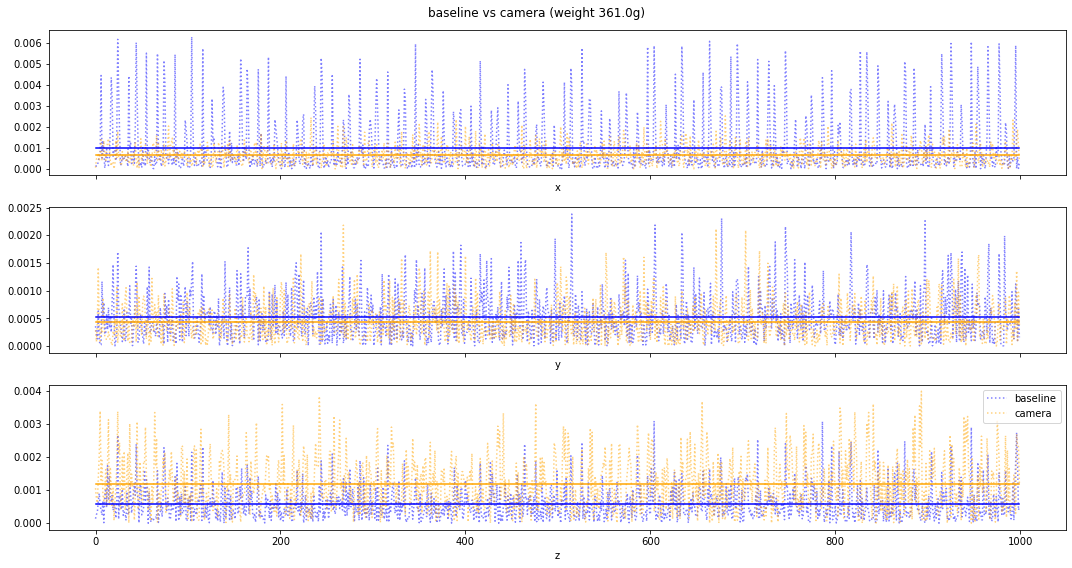

In [11]:
plot_abs_wave('camera')

In the above plots, the mean absolute amplitude is shown as the solid line and the absolute amplitudes are shown as a dotted line.

We observe:
- Across all but the z-axis vibrations of the camera (final axis, final plot), the baseline vibrations are more than the object vibrations.
- Data is quite noisy - maybe we can experiment with filtering? (tried a few preliminary ways (see `load_obj`), didn't seem to be too promising - but needs more experimentation for sure)
- z-axis seems to have minimum difference between the baseline and the object mean absolute amplitudes, which is quite unintuitive, as that is the direction in which the object is kept. Possible reasons - something to do with gravity? maybe phone case?

In any case, this suggests creating a feature given by the mean absolute amplitude of vibration in each direction.

In [12]:
# Generate a dataframe containing the mean absolute amplitude for each object's measurements
def generate_feature_df(filter_freq=False):
    records = []

    for exp_name, exp in experiment_meta.items():
        for i in range(3):
            data = load_obj(exp_name, i, filter_freq=filter_freq)
            x, y, z = data.abs().mean(axis=1)

            records.append({
                'name': exp_name,
                'weight': exp['weight'],
                'x': x,
                'y': y,
                'z': z
            })
    return pd.DataFrame(records).sort_values(by='weight').reset_index(drop=True)

feature_df = generate_feature_df()

Let's see some basic plots:

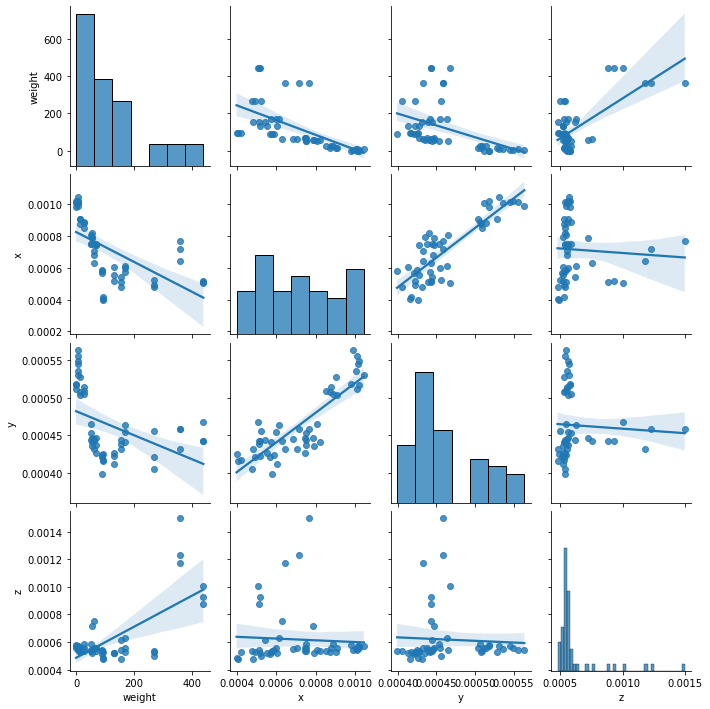

In [13]:
sns.pairplot(feature_df, kind='reg')

In [14]:
feature_df.corr()

/tmp/ipykernel_9157/1242472909.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  feature_df.corr()


,weight,x,y,z
weight,1.000000,-0.608287,-0.449294,0.692059
x,-0.608287,1.000000,0.857257,-0.059683
y,-0.449294,0.857257,1.000000,-0.054504
z,0.692059,-0.059683,-0.054504,1.000000


Observations:

- x and y axis mean absolute amplitudes (call it MAA) are negatively correlated with object weight; good start.
- x and y axis MAAs are heavily correlated with each other (0.85) - may not want to include both in a model, maybe just x as it is more correlated with weight.
- z-axis MAA is quite strange - as expected, mostly uncorrelated with x/y MAA, but positively correlated with weight? Maybe the object on the top is causing "reflected" vibrations, rather than dampening it?
- Focusing on the chart for x/y MAA, two very prominent outliers are the two objects with greatest weight - camera & glass of water. Maybe we need a remeasurement, or maybe we need separate models for low-weight/high-weight?

Note that we also have three measurements per object. From the x-axis vs weight plot above, some of these look concentrated, while some are relatively more spread out (see camera i.e. second highest set of points).

Let's look at the coefficient of variation for the measurements i.e. $\frac{\sigma}{\mu}$ i.e. a measure of the variation within groups, relative to the mean measurement.

In [15]:
coeff_v = feature_df.groupby('name').agg(lambda x: x.std()/abs(x.mean())).reset_index()
coeff_v

/tmp/ipykernel_9157/3324083550.py:1: RuntimeWarning: invalid value encountered in double_scalars
  coeff_v = feature_df.groupby('name').agg(lambda x: x.std()/abs(x.mean())).reset_index()


,name,weight,x,y,z
0,baseline,NaN,0.019800,0.007647,0.023067
1,batteries,0.0,0.040117,0.024204,0.049433
2,batteries2,0.0,0.018661,0.033462,0.029030
3,battery,0.0,0.021801,0.008085,0.045331
4,calculator,0.0,0.078910,0.017585,0.000751
5,camera,0.0,0.086988,0.033870,0.132671
6,coin,0.0,0.020192,0.025018,0.026169
7,credit_card,0.0,0.018651,0.017342,0.024686
8,garlic,0.0,0.058710,0.015280,0.184860
9,glass_of_water,0.0,0.007758,0.031830,0.067257


<Axes: >

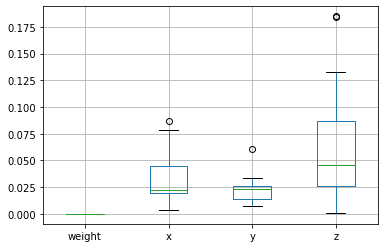

In [16]:
coeff_v.boxplot()

Most of the objects have low CVs (which is good). A few stand out - camera, for instance, possibly suggesting remeasurement; but, on the whole, x and y MAAs have relatively low CVs (75% of x-axis MAA is under 0.05 CV, and 75% of y-axis MAA is under ~0.25 CV).

The z-axis has a lot more variation, which is a bit alarming - further investigation needs to be done on the z-axis readings.

Now, let's take a closer look at the x-axis vs weight plot.

<Axes: xlabel='x', ylabel='weight'>

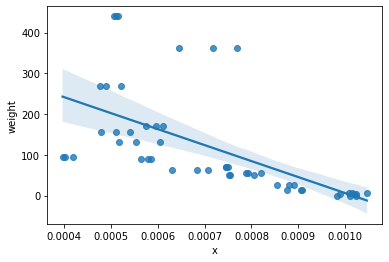

In [17]:
sns.regplot(data=feature_df, y='weight', x='x')

- Once again, we observe the outliers. There are a few plots to identify these - (studentized) residuals vs fitted values - we can use later.
- A more subtle trend is that the trend of the points after x=0.0007 i.e. objects under 100g have a less negative slope than the ones over 100g, which have a more negative slope (excluding the two heavy outliers). This may suggest a slightly more flexible model.

Let's now fit a simple linear regression model: $\text{weight} = \beta_0 + \beta_{1}\text{x-MAA}+ \beta_{2}\text{z-MAA} + \epsilon$. y is excluded for collinearity reasons.

In [18]:
model_1 = smf.ols('weight ~ x + z', data=feature_df).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 weight   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     96.95
Date:                Mon, 10 Apr 2023   Prob (F-statistic):           1.39e-17
Time:                        00:53:20   Log-Likelihood:                -277.10
No. Observations:                  51   AIC:                             560.2
Df Residuals:                      48   BIC:                             566.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    129.7860     40.538      3.202      0.002      48.278     211.294
x          -3.678e+05   4.16e+04     -8.834      0.000   -4.52e+05   -2.84e+05
z           4.061e+05   3.97e+04     10.217      0.000    3.26e+05    4.86e+05
==============================================================================
Omnibus:                        3.836   Durbin-Watson:                   0.952
Prob(Omnibus):                  0.147   Jarque-Bera (JB):                2.912
Skew:                           0.374   Prob(JB):                        0.233
Kurtosis:                       3.901   Cond. No.                     5.28e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.28e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As expected, we get a negative coefficient for x and a positive coeff. for z. Both coefficients are significant, and the R-squared is quite high. Let's see the predicted values:

In [19]:
def evaluation_df(feature_df, predictors, model):
    results = pd.DataFrame()
    results['name'] = feature_df['name']
    results['weight_true'] = feature_df['weight']
    results['weight_pred'] = model.predict(feature_df[predictors])
    results['relative_error'] = np.abs(results['weight_true'] - results['weight_pred']) / results['weight_true']

    return results

evaluation_df(feature_df, ['x', 'z'], model_1)

,name,weight_true,weight_pred,relative_error
0,baseline,0.0,4.044253,inf
1,baseline,0.0,-15.882214,inf
2,baseline,0.0,-12.677476,inf
3,credit_card,5.0,-13.101140,3.620228
4,credit_card,5.0,-13.159026,3.631805
5,credit_card,5.0,-20.042742,5.008548
6,coin,7.0,-24.034431,4.433490
7,coin,7.0,-17.303240,3.471891
8,coin,7.0,-23.597622,4.371089
9,grape,14.0,22.441412,0.602958


In [20]:
print('Mean Relative Error:', evaluation_df(feature_df, ['x', 'z'], model_1).iloc[3:, -1].mean())
print('Mean Relative Error after excluding low weight objects:', evaluation_df(feature_df, ['x', 'z'], model_1).iloc[12:, -1].mean())

Mean Relative Error: 0.855218149965224
Mean Relative Error after excluding low weight objects: 0.389178592761595


We immediately see poor performance (negative preds) for the extremely low weight objects (<10g), suggesting a potential limitation - maybe the difference in vibration magnitude is not high enough for such light objects.

The mean relative error is quite high at 85%; however, if the lightweight objects are excluded (coin, credit card, grape), then the mean relative error drops to 39%. This again suggests that we may wish to either exclude lightweight objects, or consider constructing a separate model for them.

Another model to try is the model with interactions i.e. $\text{weight} = \beta_0 + \beta_{1}\text{x-MAA}+ \beta_{2}\text{z-MAA} + \beta_{3}\text{x-MAA*z-MAA}+ \epsilon$.

In [20]:
model_2 = smf.ols('weight ~ x*z', data=feature_df).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 weight   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     95.24
Date:                Mon, 10 Apr 2023   Prob (F-statistic):           5.48e-20
Time:                        00:53:27   Log-Likelihood:                -268.44
No. Observations:                  51   AIC:                             544.9
Df Residuals:                      47   BIC:                             552.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -418.4162    130.361     -3.210      0.002    -680.670    -156.163
x            4.34e+05   1.87e+05      2.318      0.025    5.73e+04    8.11e+05
z           1.368e+06   2.23e+05      6.131      0.000    9.19e+05    1.82e+06
x:z        -1.409e+09   3.23e+08     -4.361      0.000   -2.06e+09   -7.59e+08
==============================================================================
Omnibus:                        9.182   Durbin-Watson:                   1.067
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               17.550
Skew:                           0.325   Prob(JB):                     0.000155
Kurtosis:                       5.799   Cond. No.                     4.74e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.27e-14. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

We see a moderate improvement in R-squared; coefficients are still significant.

In [21]:
evaluation_df(feature_df, ['x', 'z'], model_2)

,name,weight_true,weight_pred,relative_error
0,baseline,0.0,-1.807178,inf
1,baseline,0.0,-10.587558,inf
2,baseline,0.0,-16.352980,inf
3,credit_card,5.0,-14.886709,3.977342
4,credit_card,5.0,-3.016199,1.603240
5,credit_card,5.0,-15.550022,4.110004
6,coin,7.0,-24.779644,4.539949
7,coin,7.0,-9.846781,2.406683
8,coin,7.0,-11.017618,2.573945
9,grape,14.0,32.610319,1.329309


In [22]:
print('Mean Relative Error:', evaluation_df(feature_df, ['x', 'z'], model_2).iloc[3:, -1].mean())
print('Mean Relative Error after excluding low weight objects:', evaluation_df(feature_df, ['x', 'z'], model_2).iloc[12:, -1].mean())

Mean Relative Error: 0.7427487789865648
Mean Relative Error after excluding low weight objects: 0.34946481974430543


There is a considerable drop in the MRE.

Another model to try is the model with interactions i.e. $\text{log(weight)} = \beta_0 + \beta_{1}\text{x-MAA}+ \beta_{2}\text{z-MAA} + \beta_{3}\text{x-MAA*z-MAA}+ \epsilon$.

In [28]:
feature_df['log_weight'] = np.log(feature_df['weight'])
feature_df.head()

/home/aggdhruv/anaconda3/envs/iot/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,name,weight,x,y,z,log_weight
0,baseline,0.0,0.000983,0.000519,0.000581,-inf
1,baseline,0.0,0.001009,0.000511,0.000555,-inf
2,baseline,0.0,0.001022,0.000518,0.000575,-inf
3,credit_card,5.0,0.001019,0.000546,0.000571,1.609438
4,credit_card,5.0,0.000988,0.000564,0.000543,1.609438


In [31]:
model_3 = smf.ols('log_weight ~ x*z', data=feature_df.loc[3:,:]).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_weight   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     106.5
Date:                Mon, 10 Apr 2023   Prob (F-statistic):           3.38e-20
Time:                        01:11:25   Log-Likelihood:                -28.916
No. Observations:                  48   AIC:                             65.83
Df Residuals:                      44   BIC:                             73.32
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.0079      1.238      4.852      0.000       3.512       8.503
x          -4800.6447   1780.339     -2.696      0.010   -8388.683   -1212.606
z           3612.2296   2117.227      1.706      0.095    -654.760    7879.219
x:z        -1.592e+06   3.07e+06     -0.519      0.606   -7.77e+06    4.59e+06
==============================================================================
Omnibus:                        3.239   Durbin-Watson:                   0.881
Prob(Omnibus):                  0.198   Jarque-Bera (JB):                2.971
Skew:                          -0.600   Prob(JB):                        0.226
Kurtosis:                       2.781   Cond. No.                     4.60e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.27e-14. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [33]:
def evaluation_df_log(feature_df, predictors, model):
    results = pd.DataFrame()
    results['name'] = feature_df['name']
    results['weight_true'] = feature_df['weight']
    results['weight_pred'] = np.exp(model.predict(feature_df[predictors]))
    results['relative_error'] = np.abs(results['weight_true'] - results['weight_pred']) / results['weight_true']

    return results

In [34]:
evaluation_df_log(feature_df, ['x', 'z'], model_3)

,name,weight_true,weight_pred,relative_error
0,baseline,0.0,11.924152,inf
1,baseline,0.0,9.746523,inf
2,baseline,0.0,9.429010,inf
3,credit_card,5.0,9.527763,0.905553
4,credit_card,5.0,10.703560,1.140712
5,credit_card,5.0,9.052839,0.810568
6,coin,7.0,8.116734,0.159533
7,coin,7.0,9.731089,0.390156
8,coin,7.0,9.242911,0.320416
9,grape,14.0,19.703260,0.407376


In [36]:
print('Mean Relative Error:', evaluation_df_log(feature_df, ['x', 'z'], model_3).iloc[3:, -1].mean())
print('Mean Relative Error after excluding low weight objects:', evaluation_df_log(feature_df, ['x', 'z'], model_3).iloc[12:, -1].mean())

Mean Relative Error: 0.39255224147857753
Mean Relative Error after excluding low weight objects: 0.3656761427048343


We clearly see that there is a significant drop in Mean Relative Error indicating that low weight objects are being weighed more accurately as compared to the other significant models.
However, the mean relative error for higher weight objects is between that of the previous 2 models.

Experimenting with particular range of weights and the given models

In [65]:
def limit_weight_range(feature_df, low = 0, high = 440):
    filtered_feature_df = feature_df.loc[(low <= feature_df.weight) & (high >= feature_df.weight)]
    return filtered_feature_df

In [90]:
def compare_models(filtered_feature_df):
    models = [smf.ols('weight ~ x + z', data=filtered_feature_df),
         smf.ols('weight ~ x*z', data=filtered_feature_df),
         smf.ols('log_weight ~ x*z', data=filtered_feature_df)] # might need to remove rows with weight = 0 if present as log does not have value

    for index, model in enumerate(models):
        eval_model = model.fit()
#         print(eval_model.summary())
        if (index < 2):
#             print(evaluation_df(filtered_feature_df, ['x', 'z'], eval_model))
            print('Mean Relative Error:', evaluation_df(filtered_feature_df, ['x', 'z'], eval_model).iloc[:,-1].mean())
            print()
        else:
            print('Mean Relative Error:', evaluation_df_log(filtered_feature_df, ['x', 'z'], eval_model).iloc[:,-1].mean())

In [91]:
filtered_feature_df = limit_weight_range(feature_df, 10, 300)
compare_models(filtered_feature_df)

Mean Relative Error: 0.30611842140613127

Mean Relative Error: 0.36759686903752586

Mean Relative Error: 0.3614439743480276


In [94]:
filtered_feature_df = limit_weight_range(feature_df, 30, 300)
compare_models(filtered_feature_df)

Mean Relative Error: 0.31260294211107353

Mean Relative Error: 0.3307664353161414

Mean Relative Error: 0.28407729723088526
